## 1. Imports and helpers

In [24]:
import requests, time, json
from IPython.display import Image, Video, display
import os

BASE = "https://api.studio.nebius.com/v1/video/higgsfield"
# with open(os.path.expanduser('~/.secrets/nebius-openai-api-key')) as inp:
with open(os.path.expanduser('~/.secrets/nebius-openai-api-key-testacc')) as inp:    
    TOKEN = inp.read().strip()
HEADERS = {"Authorization": f"Bearer {TOKEN}", "accept": "application/json"}

def get(url, **kw):
    r = requests.get(url, headers=HEADERS, **kw)
    r.raise_for_status()
    return r.json()

def post(url, payload):
    r = requests.post(url, headers={**HEADERS, "Content-Type": "application/json"},
                      data=json.dumps(payload))
    r.raise_for_status()
    return r.json()

# 2. List available motions (purely informative)

In [25]:
motions = get(f"{BASE}/motions")
print("Example motions:")
for m in motions[:10]:
    print(f"  {m['name']:12} – {m['id']}")

Example motions:
  360 Orbit    – ea035f68-b350-40f1-b7f4-7dff999fdd67
  3D Rotation  – 2bae49e6-ffe7-42a8-a73f-d44632c4acaa
  Action Run   – dc8d7d9c-ae0c-45fc-b780-7d470b171b45
  Agent Reveal – 65b0a5a3-953d-471c-86d5-967ab44d0dab
  Arc          – a85cb3f2-f2be-4ee2-b3b9-808fc6a81acc
  Arc Left     – c5881721-05b1-47d9-94d6-0203863114e1
  Baseball Kick – ab0fa3d8-fcbe-4a6a-96bb-eae7a0e2c2cb
  Basketball Dunks – 1b4c1b9a-898b-451c-bff8-7288382ccaf2
  Boxing       – 4ac80533-015b-49c1-a2eb-891603823883
  Buckle Up    – a652ae99-c21b-4bdf-965c-e4a6d07fb262


# 3. Kick off a job‑set

In [26]:
IMAGE_URL = ("https://hips.hearstapps.com/hmg-prod/images/dog-puppy-on-garden-royalty-free-image-1586966191.jpg")

payload = {
    "params": {
        "model": "higgsfield/dop-turbo",
        "prompt": "Running dog",
        "seed": 2,
        "motions": [
            {"id": "dc8d7d9c-ae0c-45fc-b780-7d470b171b45", "strength": 1}
        ],
        "input_images": [{"type": "image_url", "image_url": IMAGE_URL}],
        "enhance_prompt": True,
        "check_nsfw": True
    }
}

job_set = post(f"{BASE}/job-sets", payload)
job_set_id = job_set["id"]
print(f"\nJob‑set created: {job_set_id}")


Job‑set created: c7c5e840-9771-4abe-93ae-02a72778260a


# 4. Poll until the job completes

In [27]:
status = "queued"
while status not in {"completed", "failed"}:
    time.sleep(4)                     # back‑off as needed
    job_set = get(f"{BASE}/job-sets/{job_set_id}")
    status = job_set["jobs"][0]["status"]
    print("Polling … current status:", status)

if status != "completed":
    raise RuntimeError("Generation failed ❌")

result_urls = job_set["jobs"][0]["results"]
video_url = result_urls["min"]["url"]      # or "raw" if you prefer

print("Generation finished ✅")
print("Video URL:", video_url)

Polling … current status: queued
Polling … current status: queued
Polling … current status: queued
Polling … current status: queued
Polling … current status: in_progress
Polling … current status: in_progress
Polling … current status: in_progress
Polling … current status: in_progress
Polling … current status: in_progress
Polling … current status: in_progress
Polling … current status: in_progress
Polling … current status: in_progress
Polling … current status: in_progress
Polling … current status: in_progress
Polling … current status: in_progress
Polling … current status: in_progress
Polling … current status: completed
Generation finished ✅
Video URL: https://d3u0tzju9qaucj.cloudfront.net/e3391bb0-b207-4f13-8b73-f6f4ee36bccf/1af7e348-3e50-458e-b2d1-d80f19882c61_min.mp4


# 5. Display the original image and the generated video


Original image ↓


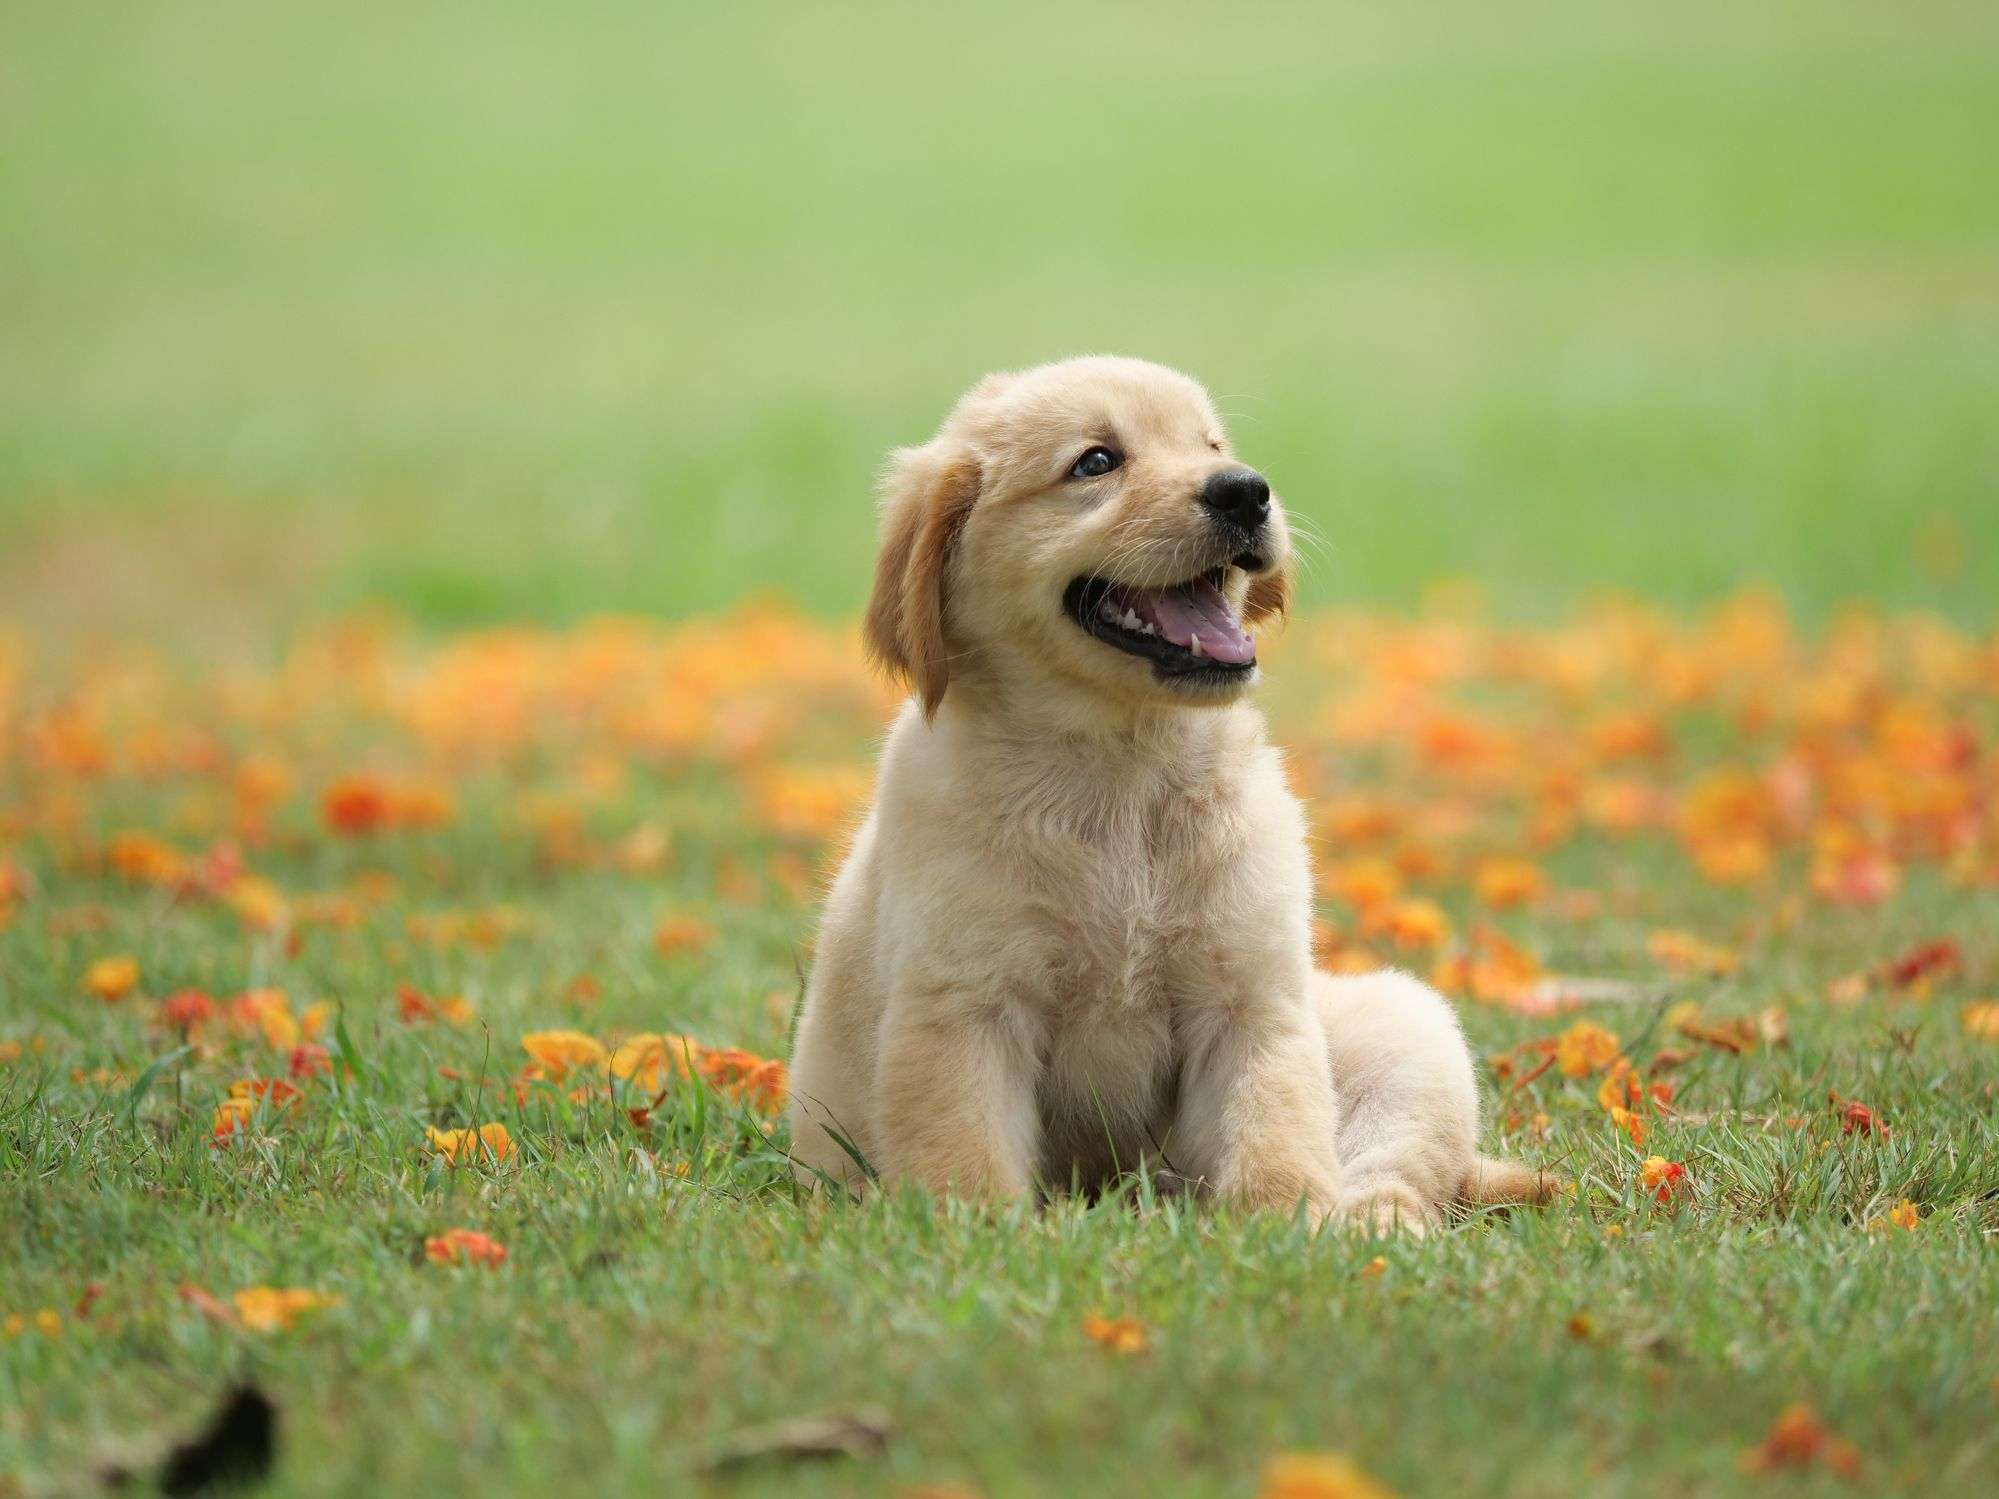


Generated video ↓


In [28]:
print("\nOriginal image ↓")
display(Image(url=IMAGE_URL, embed=True))

print("\nGenerated video ↓")
display(Video(url=video_url))
